We start by adding the necessary folders to the current working path.

In [1]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add TRA folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/TRA2D")

# add ActiveBarriers folder to current working path
sys.path.append(parent_directory+"/demos/ActiveBarriers")

# Overview

We illustrate the numerical implementation and the use of the active Trajectory Rotation Average ($ \mathrm{a\overline{TRA}} $) on 2-D homogeneous, isotropic turbulence. The active single-trajectory elliptic LCS diagnostic is applied to the two-dimensional and steady instantaneous linear momentum barrier equation. The notebook is structured as follows:

1. Import vorticity and velocity data stored in the folder 'data/Turbulence'. Make sure that all the necessary files are stored in the folder 'data/Turbulence'.
2. Define computational parameters (such as the number of cores) and variables.
3. Define spatio-temporal domain.
4. Instantaneous linear momentum barriers from active Trajectory Rotation Angle ($ \mathrm{a\overline{TRA}} $):
   
   For 2D incompressible, uniform-density Navier–Stokes flows, the Eulerian barrier equation for linear momentum is an autonomous Hamiltonian system of the form:
   
   \begin{equation}
   \mathbf{x'}(s) = \nu \rho \nabla \hat{\omega}(\mathbf{x}, t) \label{eq: linearmoment} \tag{1}
   \end{equation}
    
    Time 't' is just a fixed parameter and hence the system is autonomous and the integration is done with respect to a dummy time variable 's'. 's' can be arbitrarily large and the $ \mathrm{a\overline{TRA}} $ is only limited by the spatial resolution and domain. $ \hat{\omega} $ is the scalar valued vorticity.
    
   We start by evaluating the right-hand-side of equation \ref{eq: linearmoment} by interpolating $ \nabla \mathbf{\omega}(\mathbf{x}, t) $ over the spatial meshgrid.
   
   Apply the $ \mathrm{a\overline{TRA}} $ to the autonomous ODE from equation \ref{eq: linearmoment} on different dummy time-intervals.

5. References

# Import data

We start by importing the turbulence-data from the files located in the folder 'data/Turbulence'.

In [2]:
# import scipy
import scipy.io

# import numpy
import numpy as np

# load vorticity data
turb_w = parent_directory + r'/data/Turbulence/turb_w'

omega = np.zeros((1024, 1024, 251))

# iterate over all files in folder 'turb_w' and load vorticity data
i = 0
for filename in sorted(os.listdir(turb_w)):
    if filename.endswith(".mat"):
        file_w = os.path.join(turb_w, filename)
        mat_turb_w = scipy.io.loadmat(file_w)
        omega[:,:,i] = mat_turb_w['w']
        i+=1

# load velocity data
turb_u = parent_directory + r'/data/Turbulence/turb_u'
      
# iterate over all files in folder 'turb_u' and load velocity data
i = 0
U = np.zeros((1024, 1024, 251))
V = np.zeros((1024, 1024, 251))
for filename in sorted(os.listdir(turb_u)):
    if filename.endswith(".mat"):
        file_u = os.path.join(turb_u, filename)
        mat_turb_u = scipy.io.loadmat(file_u)
        U[:,:,i] = mat_turb_u['u1']
        V[:,:,i] = mat_turb_u['u2']
        i+=1

# load x/y grid
X = scipy.io.loadmat(parent_directory + r'/data/Turbulence/grid.mat')['x']
Y = X.copy().transpose()

# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# Number of cores for parallel computing
Ncores = 4

# time-interval over which data is defined
time_data = np.linspace(0, 25, 251, endpoint = True).reshape(1, -1)

# time resolution of data
dt_data = time_data[0,1]-time_data[0,0]

# periodic boundary conditions
periodic_x = True
periodic_y = True
periodic_t = False
periodic = [periodic_x, periodic_y, periodic_t]

# unsteady velocity field
bool_unsteady = True

# defined domain
# This array denotes where the velocity field is defined (=1) and where it is not defined (=0)
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
# specify time at which to compute instantaneous momentum barriers (this should be an integer in [0, 249])
t0 = 0

# domain boundary
xmin = 4.2
xmax = 5
ymin = 2.2
ymax = 3

Nx = 300
Ny = 300

# specify domain over which to compute linear momentum barriers
x_domain = np.linspace(xmin, xmax, Nx)
y_domain = np.linspace(ymin, ymax, Ny)

# make sure that the spatio-temporal you defined are within the domain of the data
assert np.min(X) <= xmin <= np.max(X), " xmin must be between "+f'{np.min(X)} and {np.max(X)}'
assert np.min(X) <= xmax <= np.max(X), " xmax must be between "+f'{np.min(X)} and {np.max(X)}'
assert np.min(Y) <= ymin <= np.max(Y), " ymin must be between "+f'{np.min(Y)} and {np.max(Y)}'
assert np.min(Y) <= ymax <= np.max(Y), " ymax must be between "+f'{np.min(Y)} and {np.max(Y)}'
assert np.min(time_data) <= t0 <= np.max(time_data), " t0 must be between "+f'{np.min(time_data)} and {np.max(time_data)}'

# grid-spacing
dx = x_domain[1]-x_domain[0]
dy = y_domain[1]-y_domain[0]

#compute meshgrid
X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

# Define dummy time-intervals for computation of aFTLE
s1 = 0.05
s2 = 0.15
s3 = 0.25

s = [s1, s2, s3]
ds = 0.002
s_dummy = np.arange(0, s[-1]+ds, ds)

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .1 # float between [1/100, 1/5]
aux_grid = [aux_grid_ratio*dx, aux_grid_ratio*dy] # list (2, )

# Instantaneous linear momentum barriers from active Trajectory Rotation Angle ($ \mathrm{a\overline{TRA}} $)

We visualize elliptic linear momentum barriers by applying the $ \mathrm{\overline{TRA}} $ to the trajectories of the instantaneous linear momentum barrier equation. Whenever the $ \mathrm{\overline{TRA}} $ is applied to an active vector field, such as linear momentum, we refer to it as a$ \mathrm{\overline{TRA}} $ (active $ \mathrm{\overline{TRA}} $).

## Interpolate instantaneous momentum barrier field

We start by computing the interpolant for the instantaneous momentum barrier field. The interpolant is given by the right-hand-side of the instantaneous momentum barrier field.

In [5]:
# Import interpolation function for instantaneous active momentum barrier equation
from ipynb.fs.defs.InstantaneousActiveMomentum import InstantaneousActiveMomentum

print("Computation of the Interpolant for the Eulerian linear momentum barrier equation: Started...")

# Interpolate RHS of linear momentum barrier equation using cubic spatial interpolation
Interpolant_momentum = InstantaneousActiveMomentum(X, Y, omega[:,:,t0], aux_grid)

print("Computation of the Interpolant for the Eulerian linear momentum barrier equation: Done")

Computation of the Interpolant for the Eulerian linear momentum barrier equation: Started...
Computation of the Interpolant for the Eulerian linear momentum barrier equation: Done


## Compute active TRA

We now compute the aTRA for the trajectories resulting from the instantaneous linear momentum barrier equation.

In [6]:
# Import function to compute trajectories/velocity along trajectories
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import function to compute TRA
from ipynb.fs.defs.TRA import _TRA

# Import package for parallel computing
from joblib import Parallel, delayed

# Split x0, y0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def parallel_aTRA(x0_batch, y0_batch, s_dummy, s, verbose=False):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch]) # array (2, Nx*Ny)
    
    print("Computation of DFDt: Started...")

    # Compute gradient of flow map
    DFdt = integration_dFdt(s_dummy, X0, X, Y, Interpolant_momentum[0], Interpolant_momentum[1], periodic, False, s_dummy.reshape(1,-1))[1] # array (Nt, 2, 2, Nx*Ny)
    
    print("Computation of DFDt: Done")
    
    aTRA = np.zeros((len(s), DFdt.shape[-1]))
    
    print("Computation of the aTRA from the DFdt: Started...")
    
    counter = 0
    for idx in np.searchsorted(s_dummy, s):
        
        for i in range(DFdt.shape[2]):
            
            if verbose and i%5000:
                print("Percentage completed: ", np.around((counter+1)*np.around(i/DFdt.shape[2],4)*100/3, 4))
            
            # Compute active TRA
            aTRA[counter, i] = _TRA(s_dummy[idx], DFdt[:idx+1,:, i])
            
        counter += 1
    
    print("Computation of the aTRA from the DFdt: Done")
    
    return aTRA

In [7]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny, )
x0 = X_domain.ravel() # array (Nx*Ny,)
y0 = Y_domain.ravel() # array (Nx*Ny,)

x0_batch = list(split(x0, Ncores)) # list (Nx*Ny)
y0_batch = list(split(y0, Ncores)) # list (Nx*Ny)

results = Parallel(n_jobs=Ncores, verbose = 50)(delayed(parallel_aTRA)(x0_batch[i], y0_batch[i], s_dummy, s, verbose = True) for i in range(len(x0_batch)))

# Extract aTRA from results of parallel computing
aTRA = results[0]

for res in results[1:]:
    aTRA = np.append(aTRA, res, axis = 1)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   36.3s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   36.4s remaining:   36.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   37.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   37.2s finished


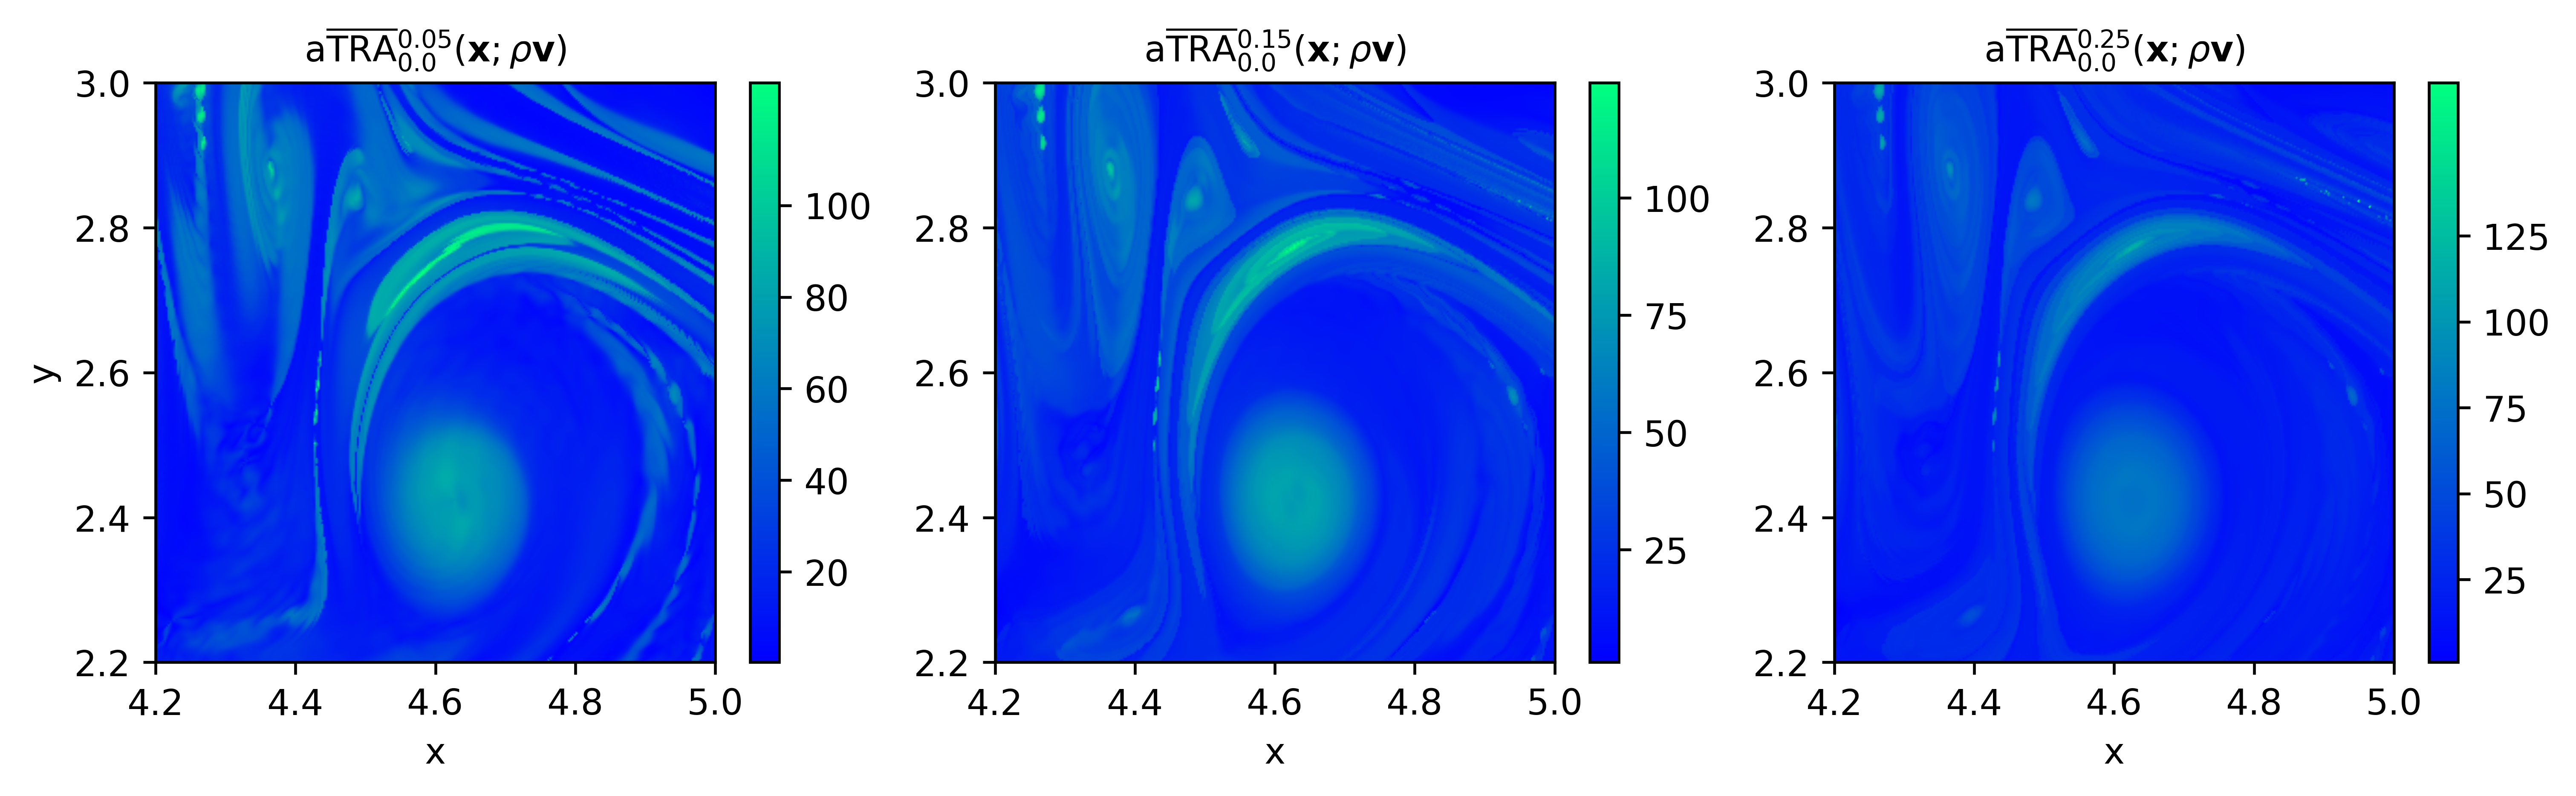

In [8]:
################################################ PLOT RESULTS ################################################

# Import plotting library
import matplotlib.pyplot as plt

# Figure/Axis
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, dpi = 600, figsize=(12, 3))

# Contourplot of aTRA_0^0.05 over meshgrid of initial conditions
cax = ax0.tricontourf(x0, y0, aTRA[0,:], cmap = "winter", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax0, ticks = np.linspace(0, 100, 6))

# Contourplot of aTRA_0^0.15 over meshgrid of initial conditions
cax = ax1.tricontourf(x0, y0, aTRA[1,:], cmap = "winter", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax1, ticks = np.linspace(0, 125, 6))

# Contourplot of aTRA_0^0.25 over meshgrid of initial conditions
cax = ax2.tricontourf(x0, y0, aTRA[2,:], cmap = "winter", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax2, ticks = np.linspace(0, 125, 6))

# Axis ticks
ax0.set_xticks(np.arange(np.min(x_domain), np.max(x_domain)+.1, 0.2))
ax1.set_xticks(np.arange(np.min(x_domain), np.max(x_domain)+.1, 0.2))
ax2.set_xticks(np.arange(np.min(x_domain), np.max(x_domain)+.1, 0.2))

ax0.set_yticks(np.arange(np.min(y_domain), np.max(y_domain)+.1, 0.2))
ax1.set_yticks(np.arange(np.min(y_domain), np.max(y_domain)+.1, 0.2))
ax2.set_yticks(np.arange(np.min(y_domain), np.max(y_domain)+.1, 0.2))

# Axis Labels
ax2.set_xlabel("x", fontsize = 10)
ax0.set_xlabel("x", fontsize = 10)
ax0.set_ylabel("y", fontsize = 10)
ax1.set_xlabel("x", fontsize = 10)

ax0.set_title(r'$ \mathrm{a\overline{TRA}}$'+f'$_{{{np.around(s_dummy[0], 2)}}}^{{{np.around(s_dummy[np.searchsorted(s_dummy, s[0])], 2)}}}$'+r'($\mathbf{x}; \rho \mathbf{v}$)', fontsize = 10)
ax1.set_title(r'$ \mathrm{a\overline{TRA}}$'+f'$_{{{np.around(s_dummy[0], 2)}}}^{{{np.around(s_dummy[np.searchsorted(s_dummy, s[1])], 2)}}}$'+r'($\mathbf{x}; \rho \mathbf{v}$)', fontsize = 10)
ax2.set_title(r'$ \mathrm{a\overline{TRA}}$'+f'$_{{{np.around(s_dummy[0], 2)}}}^{{{np.around(s_dummy[np.searchsorted(s_dummy, s[2])], 2)}}}$'+r'($\mathbf{x}; \rho \mathbf{v}$)', fontsize = 10)

plt.show()

The figures focus on momentum-based active barriers in one of the vortical regions of the two-dimensional turbulence model. The $ \mathrm{a\overline{TRA}} $ provides a clear picture of the main vortex. The features become even more pronounced for longer s-times, revealing several secondary vortices around its neighbourhood.

# References

[1] Haller, G., Katsanoulis, S., Holzner, M., Frohnapfel, B., & Gatti, D. (2020). Objective barriers to the transport of dynamically active vector fields. Journal of Fluid Mechanics, 905.

[2] Notebook 9.8. in "Transport Barriers and Coherent Structures in Flow Data" by Prof. George Haller.

[3] [YouTube Tutorial](https://youtu.be/4YwqRtyN0CI)